In [1]:
import numpy as np

# read data from text files
with open('data/reviews.txt', 'r') as f:
    reviews = f.read()
with open('data/labels.txt', 'r') as f:
    labels = f.read()

from string import punctuation


# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()

# feel free to use this import
from collections import Counter

## Build a dictionary that maps words to integers
vocab_to_int = {word:ii+1 for ii,word in enumerate(set(words))}
#counts = Counter(words)
#vocab_sort = sorted(counts,key= counts.get,reverse=True)
#vocab_to_int = {word:ii for ii,word in enumerate(vocab_sort,1)}
## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints

reviews_ints = []
for review in reviews_split:
    review_ints = []
    for word in review.split():
        word_to_int = vocab_to_int[word]
        review_ints.append(word_to_int)
    reviews_ints.append(review_ints)


label_split = labels.split('\n')
encoded_labels = []
for label in label_split:
    if label == 'positive':
        label = 1
    else:
        label = 0
    encoded_labels.append(label)


for i in range(len(reviews_ints)):
    if len(reviews_ints[i]) == 0:
        reviews_ints.pop(i)
        encoded_labels.pop(i)


def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's
        or truncated to the input seq_length.
    '''
    ## implement function
    features = []
    for review in reviews_ints:
        if len(review) < seq_length:
            zero_list = np.zeros((seq_length - len(review))).tolist()
            review = zero_list + review
        else:
            review = review[:seq_length]
        features.append(review)
    features = np.array(features).astype(np.int)
    features = np.array(features).reshape((len(reviews_ints), seq_length))

    return features

seq_length = 400
features = pad_features(reviews_ints, seq_length=seq_length)

split_frac = 0.8
encoded_labels = np.array(encoded_labels)
## split data into training, validation, and test data (features and labels, x and y)
train_x,val_test_x = features[:int(len(features)*split_frac)],features[int(len(features)*split_frac):]
val_x,test_x = val_test_x[:len(val_test_x)//2],val_test_x[len(val_test_x)//2:]

train_y,val_test_y = encoded_labels[:int(len(encoded_labels)*split_frac)],encoded_labels[int(len(encoded_labels)*split_frac):]
val_y,test_y = val_test_y[:len(val_test_y)//2],val_test_y[len(val_test_y)//2:]


import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')



Training on GPU.


In [2]:
import torch.nn as nn


class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # define all layers
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim*seq_length, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_size)
        # dropout layer
        self.dropout = nn.Dropout(0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
       # x = torch.LongTensor(x)
        embed = self.embed(x)
        embed = embed.view(batch_size,1,-1)
        output, hidden = self.lstm(embed, hidden)
        output = output.contiguous().view(-1, self.hidden_dim)
        output = self.fc1(output)
        sig_out = self.sigmoid(output)
       # sig_out = sig_out.view(batch_size, -1)
      #  sig_out = sig_out[:, -1]

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden



In [3]:
import matplotlib.pyplot as plt
def train(net,epochs,train_loader,valid_loader,clip,print_every,lr = 0.001):
    # train for some number of epochs
    # loss and optimization functions
    

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    counter = 0
    loss_min = np.inf
    losses_train = []
    losses_valid = []
    accuracies_e = []
    
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        train_loss = []
        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output, h = net(inputs, h)
            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                accuracy = []
                num_correct = 0
                
                for inputs, labels in valid_loader:

                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    if (train_on_gpu):
                        inputs, labels = inputs.cuda(), labels.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output.squeeze(), labels.float())
                    val_losses.append(val_loss.item())
                    
                    pre = torch.round(output)
                    correct_tensor = pre.eq(labels.float().view_as(pre))
                    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
                    num_correct += np.sum(correct)
                 #   accu = torch.mean(equal.float())

                    
                    #accuracy.append(accu.item())
                valid_acc = num_correct / len(valid_loader.dataset)
                net.train()
                
                losses_train.append(np.mean(train_loss))
                losses_valid.append(np.mean(val_losses))
                accuracies_e.append(valid_acc)
                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Train Loss: {:.6f}...".format(np.mean(train_loss)),
                      "Val Loss: {:.6f}...".format(np.mean(val_losses)),
                      'Val Accuracy:{}'.format(valid_acc))
                if np.mean(val_losses)<loss_min:
                    print('loss decreasing...')
                    torch.save(net.state_dict(),'net_emotion_loss_min_new.pth')
                    loss_min = np.mean(val_losses)
    print('min loss',loss_min)
    plt.plot(losses_train,color='r',label='train_loss')
    plt.plot(losses_valid,color='g',label='valid_loss')
    plt.title('Loss_Trend')
    plt.xlabel('steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('emotion_loss_new.svg')
    return accuracies_e

def test(net,test_loader):
    # Get test data loss and accuracy
    lr = 0.001

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    test_losses = []  # track loss
    num_correct = 0

    # init hidden state
    h = net.init_hidden(batch_size)

    net.eval()
    class_correct = np.zeros(2)
    class_total = np.zeros(2)
    classes = ['negative','positive']
    # iterate over test data
    for inputs, y in test_loader:

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if (train_on_gpu):
            inputs, y = inputs.cuda(), y.cuda()
        # get predicted outputs
        output, h = net(inputs, h)

        # calculate loss
        test_loss = criterion(output.squeeze(), y.float())
        test_losses.append(test_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        correct_tensor = pred.eq(y.float().view_as(pred))
        for i in range(y.shape[0]):
            label = y.data[i].item()
            class_correct[label] += correct_tensor[i].item()
            class_total[label] += 1
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)

    # -- stats! -- ##
    # avg test loss
    for i in range(2):
        if class_total[i]>0:
            print('Test Accuracy of {}:{:.4f}({}/{})'.format(classes[i],100*class_correct[i]/class_total[i],
                 int(np.sum(class_correct[i])),
                 int(np.sum(class_total[i]))))
        else:
            print('Test Accuracy of {}:N/A(no examples)'.format(classes[i]))
    print('Test Accuracy(Overall):{:.4f} ({}/{})'.format(100*np.sum(class_correct)/np.sum(class_total),
                                                    int(np.sum(class_correct)),
                                                    int(np.sum(class_total))))
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    # accuracy over all test data
    test_acc = num_correct / len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

def predict(net, test_review, sequence_length=50):
    ''' Prints out whether a give review is predicted to be
        positive or negative in sentiment, using a trained model.

        params:
        net - A trained net
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''
    test_review = test_review.lower()
    test_review = ''.join([c for c in test_review if c not in punctuation])
    test_split = test_review.split()
    review_to_int = [[vocab_to_int[word] for word in test_split]]
    feature = pad_features(review_to_int, sequence_length)

    feature_tensor = torch.from_numpy(feature)
    batch_size = feature_tensor.size(0)
    # initialize hidden state
    h = net.init_hidden(batch_size)
    if train_on_gpu:
        feature_tensor = feature_tensor.cuda()
    output, h = net(feature_tensor, h)
    pred = torch.round(output.squeeze())

    if pred == 1:
        print('It is a positive review')
    else:
        print('It is a negative review')



SentimentRNN(
  (embed): Embedding(74073, 1)
  (lstm): LSTM(400, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (sigmoid): Sigmoid()
)
Epoch: 1/4... Step: 100... Train Loss: 0.699555... Val Loss: 0.694881... Val Accuracy:0.5116
loss decreasing...
Epoch: 1/4... Step: 200... Train Loss: 0.697900... Val Loss: 0.689190... Val Accuracy:0.5456
loss decreasing...
Epoch: 1/4... Step: 300... Train Loss: 0.692972... Val Loss: 0.647269... Val Accuracy:0.632
loss decreasing...
Epoch: 1/4... Step: 400... Train Loss: 0.668569... Val Loss: 0.521374... Val Accuracy:0.7476
loss decreasing...
Epoch: 2/4... Step: 500... Train Loss: 0.433959... Val Loss: 0.466097... Val Accuracy:0.7832
loss decreasing...
Epoch: 2/4... Step: 600... Train Loss: 0.414786... Val Loss: 0.435196... Val Accuracy:0.8008
loss decreasing...
Epoch: 2/4... Step: 700... Train Loss: 0.402936... Val Loss: 0.414498... Val Accuracy:0.8112
loss decreasing...
Epo

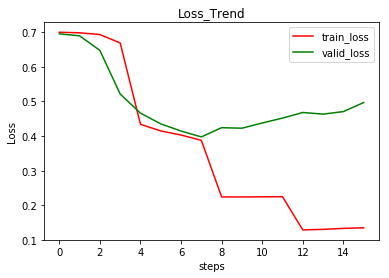

In [16]:

import torch

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1
output_size = 1
embedding_dim = 1
hidden_dim = 128
n_layers = 1

net_train = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
if(train_on_gpu):
    net_train.cuda()
print(net_train)

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing
print_every = 100
clip=5 # gradient clipping
from time import time
start = time()
accuracy= train(net_train,epochs,train_loader,valid_loader,clip,print_every,0.01)
print('Training time is:',time()-start,'s')

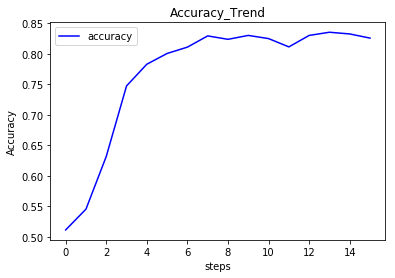

In [17]:
plt.plot(accuracy,color='b',label='accuracy')
plt.title('Accuracy_Trend')
plt.xlabel('steps')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('emotion_accuracy_new.svg')

In [18]:
vocab_size = len(vocab_to_int)+1
output_size = 1
embedding_dim = 1
hidden_dim = 128
n_layers = 1

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net.load_state_dict(torch.load('net_emotion_loss_min_new.pth'))
if(train_on_gpu):
    net.cuda()

test(net,test_loader)
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'
predict(net, test_review_neg, sequence_length=seq_length)


test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'
predict(net, test_review_pos, sequence_length=seq_length)


Test Accuracy of negative:84.9600(1062/1250)
Test Accuracy of positive:79.7600(997/1250)
Test Accuracy(Overall):82.3600 (2059/2500)
Test loss: 0.409
Test accuracy: 0.824
It is a negative review
It is a positive review
